This notebook present the performance of kriging in a continuous area in the central US

In [1]:
from __future__ import division
from torch import nn
import geopandas as gp
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mlt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import random
import copy
import scipy.sparse as sp
from utils import *
import warnings
warnings.filterwarnings('ignore')
from basic_structure import D_GCN, C_GCN, K_GCN,IGNNK
%matplotlib inline
import seaborn as sns
import heapq
plt.rcParams['figure.figsize'] = (20, 10)

/home/dingyizhuang/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
url_census='data/ushcn/tl_2017_us_state/tl_2017_us_state.shp'
A,X,_= load_udata()
X = X[:,:,:,0]
X = X.reshape(1218,120*12)
X = X/100
capacities = np.max(X,axis=1)
X=X.T
meta_locations = pd.read_csv('data/ushcn/latlon.csv',header=None, names=['latitude','longitude'])
meta_locations = meta_locations.astype('float32')
map_us=gp.read_file(url_census,encoding="utf-8")

In [5]:
w = np.max(meta_locations['longitude'])-np.min(meta_locations['longitude'])
h = np.max(meta_locations['latitude'])-np.min(meta_locations['latitude'])
lng_cond = (meta_locations['longitude']>(np.min(meta_locations['longitude']) + w/4))&(meta_locations['longitude']<(np.min(meta_locations['longitude']) + w/4*3  ))
lat_cond = (meta_locations['latitude']>(np.min(meta_locations['latitude']) + h/4))&(meta_locations['latitude']<(np.min(meta_locations['latitude'])+ h/4*3  ))
unknow_set_central = np.where(lng_cond&lat_cond)[0]
unknow_set_central = set(unknow_set_central)
full_set = set(range(0,X.shape[1]))
know_set = full_set - unknow_set_central

In [6]:
def kNN(A_new, test_set, full_set, unknow_set):
    know_set = full_set - unknow_set

    prediction = np.zeros(test_set.shape)
    prediction[:, list(know_set)] = test_set[:, list(know_set)]
    
    for index in list(unknow_set):
        Distance = []
        for index_k in list(know_set):
            Distance.append(A_new[index, index_k])
            min_num_index_list = map(Distance.index, heapq.nlargest(3, Distance))
            
        for choose in min_num_index_list:
            prediction[:, index] = prediction[:, index] + prediction[:, list(know_set)[choose]]/3
    output = prediction.copy()
    prediction[test_set == 0] = 0
    
    missing_index = np.ones(np.shape(test_set))
    missing_index[:, list(unknow_set)] = 0
    
    test_mask = 1 - missing_index
    test_mask[test_set == 0] = 0
    MAE = np.sum(np.abs(prediction - test_set))/np.sum(test_mask)
    
    RMSE = np.sqrt(np.sum((prediction - test_set)*(prediction - test_set))/np.sum(test_mask)) 
    MAPE = np.sum(np.abs(prediction - test_set)/(test_set + 1e-5))/np.sum(test_mask)
    return MAE, RMSE, MAPE , output

Load IGNNK models

In [8]:
# Load IGNNC model for central missing
space_dim = 900 # randomly set 50 of them are missing, training with dynamic graph
time_dim = 6
hidden_dim_s = 100
hidden_dim_t = 15
rank_s = 20
rank_t = 4
K=1
E_maxvalue = 80
STmodel = IGNNK(time_dim,hidden_dim_s,K)

params_old = torch.load('model/GCNmodel_udata_carea.pth')
params_new = {'GNN1.Theta1':params_old['SC1.Theta1'],
              'GNN1.bias':params_old['SC1.bias'],
              'GNN2.Theta1':params_old['SC2.Theta1'],
              'GNN2.bias':params_old['SC2.bias'],
              'GNN3.Theta1':params_old['SC3.Theta1'],
              'GNN3.bias':params_old['SC3.bias']} # Keys redefined, does not influece the result
STmodel.load_state_dict(params_new)

udata_sim = joblib.load('model/udata_sim.joblib')
MAE_t, RMSE_t, MAPE_t, udata_ignnk= test_error_cap(STmodel, unknow_set_central, full_set, X, A,time_dim,capacities)
MAE, RMSE, MAPE, udata_knn = kNN(udata_sim, X,  full_set, unknow_set_central)
print(MAE_t, RMSE_t, MAPE_t)
print(MAE, RMSE, MAPE)

3.5769151531227865 5.12747799165521 1.675010677077662
3.711297200952198 5.507727572637243 1.1558151324011128


Load baseline models

In [12]:
# Load baselines
udata_true = X
gltl = scipy.io.loadmat('model/gltl_result_udata_miss_area_central519_mu5_sigma0.05.mat')
udata_gltl = gltl['sol_cokriging']
print(udata_gltl.shape)
print(udata_ignnk.shape)
print(udata_knn.shape)
print(udata_true.shape)

(1440, 1218)
(1440, 1218)
(1440, 1218)
(1440, 1218)


Full view of the kriging performance

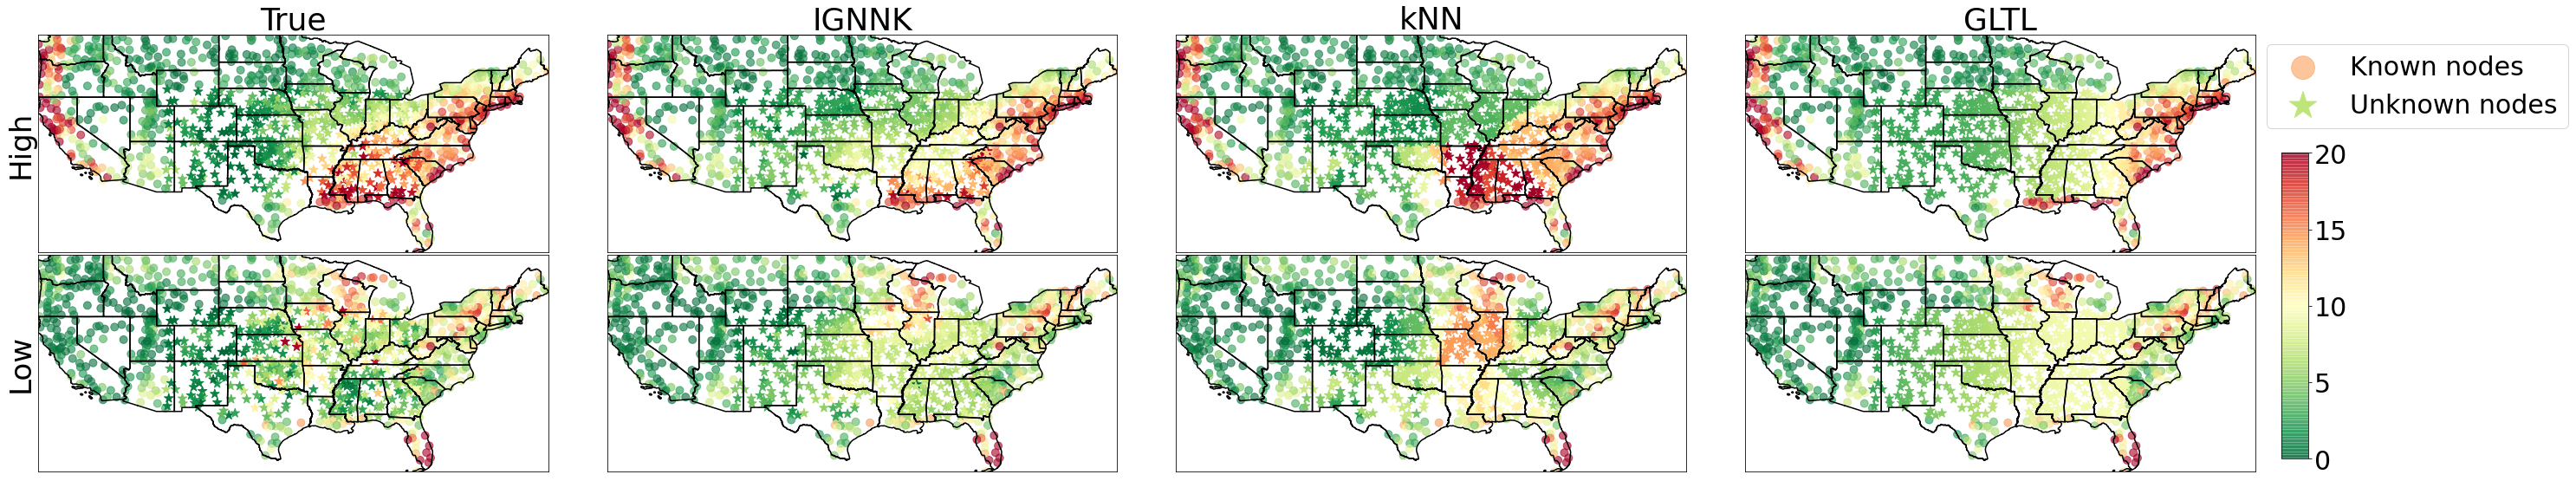

In [17]:
# udata central missing 
fig,axes = plt.subplots(2,4,figsize = (42,7))
lng_div = 0.02
lat_div = 0.01
crowd = [180,200] 
ylbs = ['High','Low']
s_known = 80
s_unknow = 120
x_max = 30 
for row in range(2):
    for col in range(4):
        ax = axes[row,col]
        map_us.boundary.plot(ax=ax,color='black')
        ax.set_xlim((np.min(meta_locations['longitude'])-lng_div,np.max(meta_locations['longitude'])+lng_div))
        ax.set_ylim((np.min(meta_locations['latitude'])-lat_div,np.max(meta_locations['latitude'])+lat_div))
        ax.set_xticks([])
        ax.set_yticks([])
        if col == 0:
            cax=ax.scatter(meta_locations['longitude'][list(know_set)],meta_locations['latitude'][list(know_set)],s=s_known,cmap=plt.cm.RdYlGn_r, c = udata_true[crowd[row],list(know_set)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = 20 ),alpha=0.6,label='Known nodes')
            cax2=ax.scatter(meta_locations['longitude'][list(unknow_set_central)],meta_locations['latitude'][list(unknow_set_central)],s=s_unknow,cmap=plt.cm.RdYlGn_r,c=udata_true[crowd[row],list(unknow_set_central)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = 20),alpha=1,marker='*',label = 'Unknown nodes')
            ax.set_ylabel(ylbs[row],fontsize=34)
            if row == 0:
                ax.set_title('True',fontsize = 36)
        elif col == 1:
            ax.scatter(meta_locations['longitude'][list(know_set)],meta_locations['latitude'][list(know_set)],s=s_known,cmap=plt.cm.RdYlGn_r, c = udata_true[crowd[row],list(know_set)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = 20),alpha=0.6)
            ax.scatter(meta_locations['longitude'][list(unknow_set_central)],meta_locations['latitude'][list(unknow_set_central)],s=s_unknow,cmap=plt.cm.RdYlGn_r,c=udata_ignnc[crowd[row],list(unknow_set_central)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = 20),alpha=1,marker='*')
            if row == 0:
                ax.set_title('IGNNK',fontsize = 36)
        elif col == 2:
            ax.scatter(meta_locations['longitude'][list(know_set)],meta_locations['latitude'][list(know_set)],s=s_known,cmap=plt.cm.RdYlGn_r, c = udata_true[crowd[row],list(know_set)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = 20),alpha=0.6)
            ax.scatter(meta_locations['longitude'][list(unknow_set_central)],meta_locations['latitude'][list(unknow_set_central)],s=s_unknow,cmap=plt.cm.RdYlGn_r,c=udata_knn[crowd[row],list(unknow_set_central)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = 20),alpha=1,marker='*')
            if row == 0:
                ax.set_title('kNN',fontsize = 36)
        else:
            ax.scatter(meta_locations['longitude'][list(know_set)],meta_locations['latitude'][list(know_set)],s=s_known,cmap=plt.cm.RdYlGn_r, c = udata_true[crowd[row],list(know_set)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = 20),alpha=0.6)
            ax.scatter(meta_locations['longitude'][list(unknow_set_central)],meta_locations['latitude'][list(unknow_set_central)],s=s_unknow,cmap=plt.cm.RdYlGn_r,c=udata_gltl[crowd[row],list(unknow_set_central)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = 20),alpha=1,marker='*')
            if row == 0:
                ax.set_title('GLTL',fontsize = 36)

fig.tight_layout()
fig.subplots_adjust(right = 0.87,hspace=0.01,wspace =0.01,bottom=0,top=1)
l = 0.87
b = 0.03
w = 0.01
h = 0.70
rect = [l,b,w,h] 
cbar_ax = fig.add_axes(rect) 

cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.ax.tick_params(labelsize=30)

plt.figlegend(handles=(cax,cax2),labels=('Known nodes','Unknown nodes'),bbox_to_anchor=(0.98, 1), loc=1, borderaxespad=0.,markerscale =3 ,fontsize = 30)
plt.savefig('fig/spatial_ushcn_full_carea_noon{:}_evening{:}.pdf'.format(crowd[0],crowd[1]))
plt.show()

Zoom into the central area

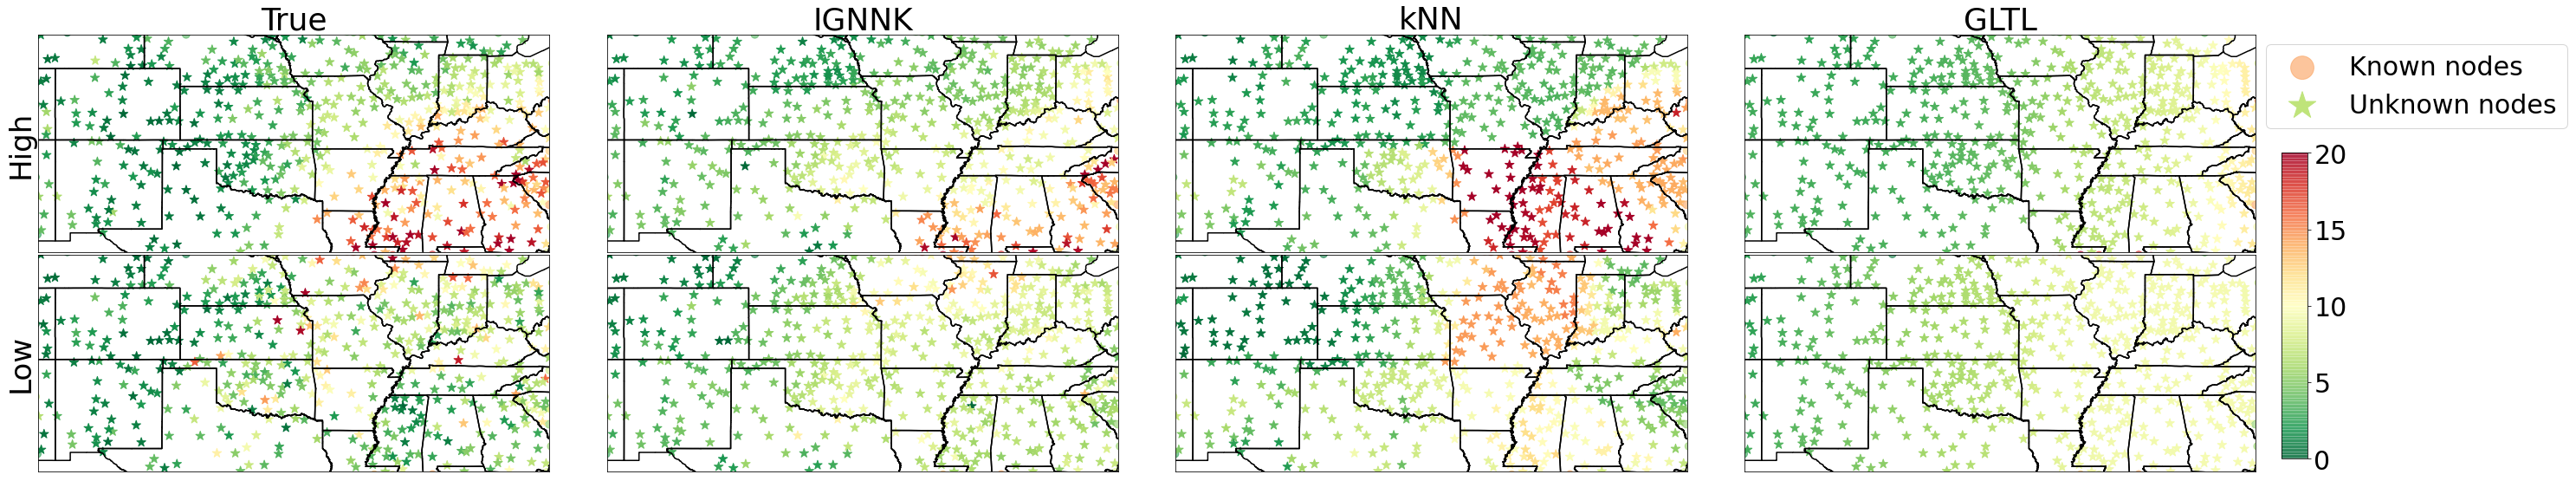

In [18]:
# udata central missing 
fig,axes = plt.subplots(2,4,figsize = (42,7))
lng_div = 0.02
lat_div = 0.01
crowd = [180,200] 
ylbs = ['High','Low']
s_known = 80
s_unknow = 120
x_max = 30 
for row in range(2):
    for col in range(4):
        ax = axes[row,col]
        map_us.boundary.plot(ax=ax,color='black')
        ax.set_xlim((np.min(meta_locations['longitude'].iloc[list(unknow_set_central)])-lng_div,np.max(meta_locations['longitude'].iloc[list(unknow_set_central)])+lng_div))
        ax.set_ylim((np.min(meta_locations['latitude'].iloc[list(unknow_set_central)])-lat_div,np.max(meta_locations['latitude'].iloc[list(unknow_set_central)])+lat_div))
        ax.set_xticks([])
        ax.set_yticks([])
        if col == 0:
            cax=ax.scatter(meta_locations['longitude'][list(know_set)],meta_locations['latitude'][list(know_set)],s=s_known,cmap=plt.cm.RdYlGn_r, c = udata_true[crowd[row],list(know_set)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = 20 ),alpha=0.6,label='Known nodes')
            cax2=ax.scatter(meta_locations['longitude'][list(unknow_set_central)],meta_locations['latitude'][list(unknow_set_central)],s=s_unknow,cmap=plt.cm.RdYlGn_r,c=udata_true[crowd[row],list(unknow_set_central)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = 20),alpha=1,marker='*',label = 'Unknown nodes')
            ax.set_ylabel(ylbs[row],fontsize=34)
            if row == 0:
                ax.set_title('True',fontsize = 36)
        elif col == 1:
            ax.scatter(meta_locations['longitude'][list(know_set)],meta_locations['latitude'][list(know_set)],s=s_known,cmap=plt.cm.RdYlGn_r, c = udata_true[crowd[row],list(know_set)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = 20),alpha=0.6)
            ax.scatter(meta_locations['longitude'][list(unknow_set_central)],meta_locations['latitude'][list(unknow_set_central)],s=s_unknow,cmap=plt.cm.RdYlGn_r,c=udata_ignnc[crowd[row],list(unknow_set_central)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = 20),alpha=1,marker='*')
            if row == 0:
                ax.set_title('IGNNK',fontsize = 36)
        elif col == 2:
            ax.scatter(meta_locations['longitude'][list(know_set)],meta_locations['latitude'][list(know_set)],s=s_known,cmap=plt.cm.RdYlGn_r, c = udata_true[crowd[row],list(know_set)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = 20),alpha=0.6)
            ax.scatter(meta_locations['longitude'][list(unknow_set_central)],meta_locations['latitude'][list(unknow_set_central)],s=s_unknow,cmap=plt.cm.RdYlGn_r,c=udata_knn[crowd[row],list(unknow_set_central)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = 20),alpha=1,marker='*')
            if row == 0:
                ax.set_title('kNN',fontsize = 36)
        else:
            ax.scatter(meta_locations['longitude'][list(know_set)],meta_locations['latitude'][list(know_set)],s=s_known,cmap=plt.cm.RdYlGn_r, c = udata_true[crowd[row],list(know_set)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = 20),alpha=0.6)
            ax.scatter(meta_locations['longitude'][list(unknow_set_central)],meta_locations['latitude'][list(unknow_set_central)],s=s_unknow,cmap=plt.cm.RdYlGn_r,c=udata_gltl[crowd[row],list(unknow_set_central)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = 20),alpha=1,marker='*')
            if row == 0:
                ax.set_title('GLTL',fontsize = 36)

fig.tight_layout()
fig.subplots_adjust(right = 0.87,hspace=0.01,wspace =0.01,bottom=0,top=1)
l = 0.87
b = 0.03
w = 0.01
h = 0.70
rect = [l,b,w,h] 
cbar_ax = fig.add_axes(rect) 

cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.ax.tick_params(labelsize=30)

plt.figlegend(handles=(cax,cax2),labels=('Known nodes','Unknown nodes'),bbox_to_anchor=(0.98, 1), loc=1, borderaxespad=0.,markerscale =3 ,fontsize = 30)
plt.savefig('fig/spatial_ushcn_central_carea_noon{:}_evening{:}.pdf'.format(crowd[0],crowd[1]))
plt.show()